In [1]:
import numpy as np
import math
import PIL
from matplotlib.pyplot import imshow

In [2]:
img = PIL.Image.open('lena.png', 'r')
key_img = PIL.Image.open('key1.2.jpg', 'r')

In [3]:
type(img)

PIL.PngImagePlugin.PngImageFile

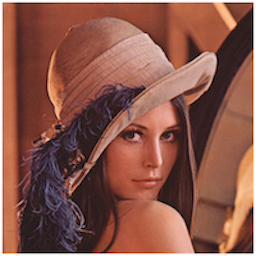

In [4]:
img

In [5]:
import cv2
img1 = cv2.imread('lena.png',0) 

In [6]:
img_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

In [7]:
img2 = np.asarray(img)

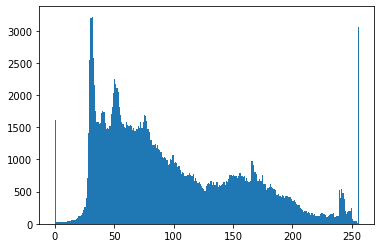

In [8]:
from matplotlib import pyplot as plt
plt.hist(img2.ravel(),256,[0,256]) 
plt.show() 

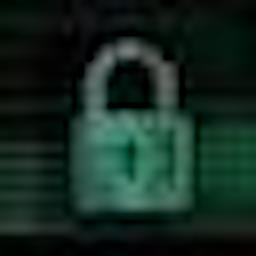

In [9]:
key_img

In [10]:
key_img.size

(256, 256)

In [11]:
pix_val_key = list(key_img.getdata())

In [12]:
pix_val_key

[(0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 10, 4),
 (0, 10, 4),
 (0, 10, 4),
 (1, 10, 5),
 (1, 10, 5),
 (1, 10, 5),
 (3, 9, 5),
 (3, 9, 5),
 (3, 9, 5),
 (3, 9, 5),
 (3, 9, 5),
 (3, 12, 9),
 (3, 12, 9),
 (3, 12, 9),
 (5, 11, 9),
 (5, 11, 9),
 (5, 11, 9),
 (5, 11, 9),
 (6, 10, 9),
 (7, 11, 10),
 (7, 11, 10),
 (8, 12, 11),
 (9, 11, 10),
 (8, 10, 9),
 (7, 9, 8),
 (6, 8, 7),
 (5, 7, 6),
 (3, 5, 4),
 (2, 4, 3),
 (1, 3, 2),
 (1, 3, 2),
 (2, 4, 3),
 (4, 6, 5),
 (5, 7, 6),
 (7, 9, 8),
 (9, 11, 10),
 (11, 13, 12),
 (12, 14, 13),
 (14, 16, 15),
 (15, 17, 16),
 (15, 17, 16),
 (1

In [13]:
key = np.array(key_img)

pix_val_key1 = []
for i in range(key.shape[0]):
    for j in range(key.shape[1]):
        pix_val_key1.append((key[i,j,0], key[i,j,1], key[i,j,2]))

In [14]:
len(pix_val_key1)

65536

In [15]:
pix_val_key1

[(0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 8, 0),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 9, 1),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 12, 5),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 11, 4),
 (0, 10, 4),
 (0, 10, 4),
 (0, 10, 4),
 (1, 10, 5),
 (1, 10, 5),
 (1, 10, 5),
 (3, 9, 5),
 (3, 9, 5),
 (3, 9, 5),
 (3, 9, 5),
 (3, 9, 5),
 (3, 12, 9),
 (3, 12, 9),
 (3, 12, 9),
 (5, 11, 9),
 (5, 11, 9),
 (5, 11, 9),
 (5, 11, 9),
 (6, 10, 9),
 (7, 11, 10),
 (7, 11, 10),
 (8, 12, 11),
 (9, 11, 10),
 (8, 10, 9),
 (7, 9, 8),
 (6, 8, 7),
 (5, 7, 6),
 (3, 5, 4),
 (2, 4, 3),
 (1, 3, 2),
 (1, 3, 2),
 (2, 4, 3),
 (4, 6, 5),
 (5, 7, 6),
 (7, 9, 8),
 (9, 11, 10),
 (11, 13, 12),
 (12, 14, 13),
 (14, 16, 15),
 (15, 17, 16),
 (15, 17, 16),
 (1

In [16]:
key_img.size

(256, 256)

In [17]:
img_arr = np.asarray(img)

In [18]:
img_arr.shape

(256, 256, 3)

In [ ]:
# resized_img = cv2.resize(img_arr, (128,128))

In [ ]:
# resized_img.shape

In [ ]:
# imshow(resized_img)

In [ ]:
# original_img = cv2.resize(img_arr, (200,200))

In [ ]:
# imshow(original_img)

In [28]:
def make_gcd_matrix(key_img):
    
    pix_val_key = []
    for i in range(key.shape[0]):
        for j in range(key.shape[1]):
            pix_val_key.append((key[i,j,0], key[i,j,1], key[i,j,2]))
    
    rows = key_img.shape[0]
    cols = key_img.shape[1]
    
    gcd_matrix = []

    temp_li = []
    for pix_val in pix_val_key:
        gcd1 = math.gcd(pix_val[0], pix_val[1])
        gcd2 = math.gcd(pix_val[1], pix_val[2])
        gcd3 = math.gcd(pix_val[2], pix_val[0])
        gcd = (gcd1, gcd2, gcd3)
        temp_li.append(gcd)
        if len(temp_li) % key_img.shape[0] == 0:
            if len(temp_li) == 0:
                temp_li = []
            else:
                gcd_matrix.append(temp_li)
                temp_li = []
          
    return gcd_matrix

def get_sum_mod(gcd_matrix):
    
    sum_mod = []
    for i in range(len(gcd_matrix)):
        temp_sum_mod1 = 0
        temp_sum_mod2 = 0
        temp_sum_mod3 = 0
        for j in range(len(gcd_matrix[i])):
            if i == j:
                continue
            temp_sum_mod1 += gcd_matrix[i][j][0]
            temp_sum_mod2 += gcd_matrix[i][j][1]
            temp_sum_mod3 += gcd_matrix[i][j][2]
            
        temp_sum_mod = [temp_sum_mod1 % 256, temp_sum_mod2 % 256, temp_sum_mod3 % 256]
        
        sum_mod.append(temp_sum_mod)
    return sum_mod

def make_matrix_table(sum_mod):
    
    dict_matrix_table = {}
    dict_matrix_table[0] = {}
    dict_matrix_table[1] = {}
    dict_matrix_table[2] = {}
    for i in range(3):
        for j in range(256):
            dict_matrix_table[i][j] = []
    
    temp_list = [[i,i,i] for i in range(256)]
    
    for i in range(256):
        for k in range(len(temp_list)):
            for j in range(3):
                temp_list[k][j] += sum_mod[i % len(sum_mod)][j]
                temp_list[k][j] = temp_list[k][j] % len(temp_list)
                
        for j in temp_list:
            for l in range(3):
                dict_matrix_table[l][i].append(j[l])
            
    return dict_matrix_table

In [ ]:
def pad_image(img, key):
    
    img_dim = img.size
    key_dim = key.size
    img_arr = np.asarray(img)
    pad_size_width = img_dim[0] % key_dim[0]
    pad_size_height = img_dim[1] % key_dim[1]
    
    if pad_size_width != 0 or pad_size_height != 0:
        arr_width = np.zeros((img_dim[1], key_dim[0]-pad_size_width, 3), dtype = 'uint8')
        arr_height = np.zeros((key_dim[1] - pad_size_height, (img_dim[0] + key_dim[0] - pad_size_width), 3), dtype = 'uint8')
        padded_img = np.concatenate((img_arr, arr_width), axis = 1)
        padded_img = np.concatenate((padded_img, arr_height), axis = 0)      
        return padded_img
    else:
        return np.asarray(img)
    

In [20]:
def trans(sum_mod):
    
    trans_mod = []
    for i in range(len(sum_mod)):
        temp = []
        for j in range(len(sum_mod[i])):
            temp.append(sum_mod[i][j] % len(sum_mod))
        trans_mod.append(temp)
        
    dim1 = []
    dim2 = []
    dim3 = []
    
    for i in range(len(trans_mod)):
        if trans_mod[i][0] not in dim1:
            dim1.append(trans_mod[i][0])
        
        if trans_mod[i][0] in dim1:
            for j in range(trans_mod[i][0]+1, len(trans_mod)):
                if j not in dim1:
                    dim1.append(j)
                    break
                if j == len(trans_mod) -1:
                    for k in range(0, trans_mod[i][0]):
                        if k not in dim1:
                            dim1.append(k)
                            break
                            
        if trans_mod[i][1] not in dim2:
            dim2.append(trans_mod[i][1])
            
        if trans_mod[i][1] in dim1:
            for j in range(trans_mod[i][1]+1, len(trans_mod)):
                if j not in dim2:
                    dim2.append(j)
                    break
                if j == len(trans_mod) -1:
                    for k in range(0, trans_mod[i][1]):
                        if k not in dim2:
                            dim2.append(k)
                            break

        if trans_mod[i][2] not in dim3:
            dim3.append(trans_mod[i][2])
            
        if trans_mod[i][2] in dim3:
            for j in range(trans_mod[i][2]+1, len(trans_mod)):
                if j not in dim3:
                    dim3.append(j)
                    break
                if j == len(trans_mod) -1:
                    for k in range(0, trans_mod[i][2]):
                        if k not in dim3:
                            dim3.append(k)
                            break
                            
    return dim1, dim2, dim3

In [21]:
def encrypt_trans(dim1, dim2, dim3, subs_cipher_img):
    
    cipher_img = np.empty(subs_cipher_img.shape, dtype = 'uint8')
    
    for i in range(subs_cipher_img.shape[0]):
        for j in range(len(dim1)):
            index = dim1[j] 
            k = 0
            while index + k * len(dim1) < cipher_img.shape[1]:
                cipher_img[i,j + k * len(dim1),0] = subs_cipher_img[i, index + len(dim1)*k, 0]
                k += 1
            
    for i in range(subs_cipher_img.shape[0]):
        for j in range(len(dim2)):
            index = dim2[j] 
            k = 0
            while index + k * len(dim2) < cipher_img.shape[1]:
                cipher_img[i,j + k * len(dim2),1] = subs_cipher_img[i, index + len(dim2)*k, 1]
                k += 1

    for i in range(subs_cipher_img.shape[0]):
        for j in range(len(dim3)):
            index = dim3[j] 
            k = 0
            while index + k * len(dim3) < cipher_img.shape[1]:
                cipher_img[i,j + k * len(dim3),2] = subs_cipher_img[i, index + len(dim3)*k, 2]
                k += 1
            
    return cipher_img

In [22]:
def encrypt_trans1(dim1, dim2, dim3, subs_cipher_img):
    
    cipher_img = np.empty(subs_cipher_img.shape, dtype = 'uint8')
    
    for j in range(subs_cipher_img.shape[1]):
        for i in range(len(dim1)):
            index = dim1[i] 
            k = 0
            while index + k * len(dim1) < cipher_img.shape[0]:
                cipher_img[i + k * len(dim1),j,0] = subs_cipher_img[index + len(dim1)*k, j, 0]
                k += 1
            
    for j in range(subs_cipher_img.shape[1]):
        for i in range(len(dim2)):
            index = dim2[i] 
            k = 0
            while index + k * len(dim2) < cipher_img.shape[0]:
                cipher_img[i+ k * len(dim2),j,1] = subs_cipher_img[index + len(dim2)*k, j, 1]
                k += 1

    for j in range(subs_cipher_img.shape[1]):
        for i in range(len(dim3)):
            index = dim3[i] 
            k = 0
            while index + k * len(dim3) < cipher_img.shape[0]:
                cipher_img[i+ k * len(dim3),j,2] = subs_cipher_img[index + len(dim3)*k, j, 2]
                k += 1
            
    return cipher_img

In [23]:
def decrypt_trans1(dim1, dim2, dim3, cipher_img):
        
    plain_img = np.empty(cipher_img.shape, dtype = 'uint8')
    
    for j in range(cipher_img.shape[1]):
        for i in range(len(dim1)):
#             current = cipher_img[i,j,0]
            index = dim1[i]
            k = 0
            while index + k * len(dim1) < cipher_img.shape[0]:
                plain_img[index + k * len(dim1),j, 0] = cipher_img[i + k * len(dim1),j,0]
                k += 1
        
    for j in range(cipher_img.shape[1]):
        for i in range(len(dim2)):
            index = dim2[i]
            k = 0
            while index + k * len(dim2) < cipher_img.shape[0]:
                plain_img[index + k * len(dim2),j, 1] = cipher_img[i + k * len(dim2),j,1]
                k += 1
                
    for j in range(cipher_img.shape[1]):
        for i in range(len(dim3)):
            index = dim3[i]
            k = 0
            while index + k * len(dim3) < cipher_img.shape[0]:
                plain_img[index + k * len(dim3),j, 2] = cipher_img[i + k * len(dim3),j,2]
                k += 1
            
    return plain_img

In [24]:
def decrypt_trans(dim1, dim2, dim3, cipher_img):
        
    plain_img = np.empty(cipher_img.shape, dtype = 'uint8')
    
    for i in range(cipher_img.shape[0]):
        for j in range(len(dim1)):
#             current = cipher_img[i,j,0]
            index = dim1[j]
            k = 0
            while index + k * len(dim1) < cipher_img.shape[1]:
                plain_img[i,index + k * len(dim1), 0] = cipher_img[i,j + k * len(dim1),0]
                k += 1
        
    for i in range(cipher_img.shape[0]):
        for j in range(len(dim2)):
            index = dim2[j]
            k = 0
            while index + k * len(dim2) < cipher_img.shape[1]:
                plain_img[i,index + k * len(dim2), 1] = cipher_img[i,j + k * len(dim2),1]
                k += 1
                
    for i in range(cipher_img.shape[0]):
        for j in range(len(dim3)):
            index = dim3[j]
            k = 0
            while index + k * len(dim3) < cipher_img.shape[1]:
                plain_img[i,index + k * len(dim3), 2] = cipher_img[i,j + k * len(dim3),2]
                k += 1
            
    return plain_img

In [29]:
gcd_matrix = make_gcd_matrix(key)
sum_mod = get_sum_mod(gcd_matrix)

In [30]:
dim1, dim2, dim3 = trans(sum_mod)       
cipher_img = encrypt_trans(dim1, dim2, dim3, img_arr)
cipher_img = encrypt_trans1(dim1, dim2, dim3, cipher_img)

NameError: name 'cipher_img' is not defined

In [ ]:
def final_encrypt(plain_img, key_img):
    
    gcd_matrix = make_gcd_matrix(key_img)
    sum_mod = get_sum_mod(gcd_matrix)
    dict_matrix_table = make_matrix_table(sum_mod)
    padded_img = pad_image(img, key_img)
#     padded_img = np.asarray(plain_img)
    key_dim = key_img.size
    key = np.asarray(key_img)
    cipher_img = np.empty(padded_img.shape, dtype = 'uint8')
    
    for i in range(padded_img.shape[0]):
        for j in range(padded_img.shape[1]):
            dict_key = key[i%key_dim[0],j%key_dim[1]]
            for k in range(3):
                cipher_img[i][j][k] = dict_matrix_table[k][dict_key[k]][padded_img[i,j,k]]
                
    dim1, dim2, dim3 = trans(sum_mod)       
    cipher_img = encrypt_trans(dim1, dim2, dim3, cipher_img)
    cipher_img = encrypt_trans1(dim1, dim2, dim3, cipher_img)
    
    return cipher_img

In [ ]:
cipher_img = final_encrypt(img, key_img)

In [ ]:
imshow(cipher_img)

In [ ]:
plt.hist(cipher_img.ravel(),256,[0,256]) 
plt.show() 

In [ ]:
gcd_matrix = make_gcd_matrix(key_img)
sum_mod = get_sum_mod(gcd_matrix)
dict_matrix_table = make_matrix_table(sum_mod)
key_dim = key_img.size
key = np.asarray(key_img)
dict_key = key[0%key_dim[0],0%key_dim[1]]
dict_matrix_table[0][dict_key[0]][0]

In [ ]:
sum_mod

In [ ]:
def final_decrypt(cipher_img, key_img):
    
    gcd_matrix = make_gcd_matrix(key_img)
    sum_mod = get_sum_mod(gcd_matrix)
    dict_matrix_table = make_matrix_table(sum_mod)
    key_dim = key_img.size
    key = np.asarray(key_img)
    dim1, dim2, dim3 = trans(sum_mod)
    
    plain_img_trans = decrypt_trans1(dim1, dim2, dim3, cipher_img)
    plain_img_trans = decrypt_trans(dim1, dim2, dim3, plain_img_trans)
    
    plain_img = np.empty(cipher_img.shape, dtype = 'uint8')

    for i in range(plain_img_trans.shape[0]):
        for j in range(plain_img_trans.shape[1]):
            dict_key = key[i%key_dim[0],j%key_dim[1]]
            for k in range(3):
#                 ind = dict_matrix_table[k][dict_key[k]].index(plain_img_trans[i,j,k])
#                 first = dict_matrix_table[k][dict_key[k]][0]
                ind = plain_img_trans[i,j,k] - dict_matrix_table[k][dict_key[k]][0]
                plain_img[i,j,k] = ind
        print(i)       
    return plain_img

In [ ]:
plain_img = final_decrypt(cipher_img, key_img)

In [ ]:
imshow(plain_img)

In [ ]:
def final_encrypt(plain_img, key_img):
    
    gcd_matrix = make_gcd_matrix(key_img)
    sum_mod = get_sum_mod(gcd_matrix)
    sum_mod[5] = [170,70,100]
    dict_matrix_table = make_matrix_table(sum_mod)
    padded_img = pad_image(img, key_img)
#     padded_img = np.asarray(plain_img)
    key_dim = key_img.size
    key = np.asarray(key_img)
    cipher_img = np.empty(padded_img.shape, dtype = 'uint8')
    
    for i in range(padded_img.shape[0]):
        for j in range(padded_img.shape[1]):
            dict_key = key[i%key_dim[0],j%key_dim[1]]
            for k in range(3):
                cipher_img[i][j][k] = dict_matrix_table[k][dict_key[k]][padded_img[i,j,k]]
                
    dim1, dim2, dim3 = trans(sum_mod)       
    cipher_img = encrypt_trans(dim1, dim2, dim3, cipher_img)
    cipher_img = encrypt_trans1(dim1, dim2, dim3, cipher_img)
    
    return cipher_img

In [ ]:
cipher_img1 = final_encrypt(img, key_img)

In [ ]:
imshow(cipher_img1)

In [ ]:
imshow(cipher_img-cipher_img1)

In [ ]:
# for i in range(180,230):
#     for j in range(180,230):
#         for k in range(3):
#             plt.scatter(img2[i,j,k], img2[i+1, j, k], s = 0.5, c = 'blue')
            
# plt.show()

In [ ]:
# for i in range(180,230):
#     for j in range(180,230):
#         for k in range(3):
#             plt.scatter(cipher_img[i,j,k], cipher_img[i+1, j, k], s = 0.5, c = 'blue')
            
# plt.show()

In [ ]:
# for i in range(45,90):
#     for j in range(50,90):
#         for k in range(3):
#             plt.scatter(img2[i,j,k], img2[i, j+1, k], s = 0.5, c = 'blue')
            
# plt.show()

In [ ]:
# for i in range(45,90):
#     for j in range(50,90):
#         for k in range(3):
#             plt.scatter(cipher_img[i,j,k], cipher_img[i, j+1, k], s = 0.5, c = 'blue')
            
# plt.show()

In [ ]:
# for i in range(50):
#     for j in range(50):
#         for k in range(3):
#             plt.scatter(img2[i,j,k], img2[i+1, j+1, k], s = 0.5, c = 'blue')
            
# plt.show()

In [ ]:
# for i in range(50):
#     for j in range(50):
#         for k in range(3):
#             plt.scatter(cipher_img[i,j,k], cipher_img[i+1, j+1, k], s = 0.5, c = 'blue')
            
# plt.show()

In [ ]:
E_p = 0
E_q = 0
for i in range(255):
    for j in range(256):
        for k in range(3):
            E_p += cipher_img[i,j,k]
            E_q += cipher_img[i+1,j,k]
            
E_p = E_p / (255*256*3)
E_q = E_q / (255*256*3)

In [ ]:
cov = 0
for i in range(255):
    for j in range(256):
        for k in range(3):
            cov += (cipher_img[i,j,k] - E_p)*(cipher_img[i+1,j,k] - E_q)
            
cov = cov / (255*256*3)

In [ ]:
D_p = 0
D_q = 0
for i in range(255):
    for j in range(256):
        for k in range(3):
            D_p += (cipher_img[i,j,k] - E_p)**2
            D_q += (cipher_img[i+1,j,k] - E_q)**2
            
D_p = D_p / (255*256*3)
D_q = D_q / (255*256*3)
            

In [ ]:
import math
corr = cov / (math.pow(D_p, 0.5) * math.pow(D_q, 0.5))

In [ ]:
corr

In [ ]:
E_p = 0
E_q = 0
for i in range(256):
    for j in range(255):
        for k in range(3):
            E_p += cipher_img[i,j,k]
            E_q += cipher_img[i,j+1,k]
            
E_p = E_p / (255*256*3)
E_q = E_q / (255*256*3)

In [ ]:
cov = 0
for i in range(256):
    for j in range(255):
        for k in range(3):
            cov += (cipher_img[i,j,k] - E_p)*(cipher_img[i,j+1,k] - E_q)
            
cov = cov / (255*256*3)

In [ ]:
D_p = 0
D_q = 0
for i in range(256):
    for j in range(255):
        for k in range(3):
            D_p += (cipher_img[i,j,k] - E_p)**2
            D_q += (cipher_img[i,j+1,k] - E_q)**2
            
D_p = D_p / (255*256*3)
D_q = D_q / (255*256*3)

In [ ]:
corr = cov / (math.pow(D_p, 0.5) * math.pow(D_q, 0.5))

In [ ]:
corr

In [ ]:
E_p = 0
E_q = 0
for i in range(255):
    for j in range(255):
        for k in range(3):
            E_p += cipher_img[i,j,k]
            E_q += cipher_img[i+1,j+1,k]
            
E_p = E_p / (255*255*3)
E_q = E_q / (255*255*3)

In [ ]:
cov = 0
for i in range(255):
    for j in range(255):
        for k in range(3):
            cov += (cipher_img[i,j,k] - E_p)*(cipher_img[i+1,j+1,k] - E_q)
            
cov = cov / (255*255*3)

In [ ]:
D_p = 0
D_q = 0
for i in range(255):
    for j in range(255):
        for k in range(3):
            D_p += (cipher_img[i,j,k] - E_p)**2
            D_q += (cipher_img[i+1,j+1,k] - E_q)**2
            
D_p = D_p / (255*255*3)
D_q = D_q / (255*255*3)

In [ ]:
corr = cov / (math.pow(D_p, 0.5) * math.pow(D_q, 0.5))

In [ ]:
corr

In [ ]:
img_arr[100][100]

In [ ]:
img_arr_changed = img_arr.copy()
img_arr_changed[100][100] = [160, 250, 9]
img_arr_changed[100][101] = [160, 250, 9]
img_arr_changed[101][100] = [160, 250, 9]
img_arr_changed[101][101] = [160, 250, 9]

In [ ]:
imshow(img_arr-img_arr_changed)

In [ ]:
cipher_img1 = final_encrypt(img_arr_changed, key_img)

In [ ]:
imshow(cipher_img1)

In [ ]:
imshow(cipher_img-cipher_img1)